# Taking a look at the cMSSM dataset

The constrained Minimimal Supersymmetric Standard Model (cMSSM) is the simplest realistic supersymmetric extension of the Standard Model of Particle Physics.
Supersymmetry is an additional symmetry that introduces new particles, superpartners to the normal particles.
This symmetry is broken in some unknown way, and this means that unconstrained MSSM has ~100 free parameters.

In cMSSM this is reduced to four (and a half) parameters by making some assumptions at the so-called Grand Unification (GUT) scale (much higher energy than accessable by terrestial experiments.)
The assumtions, and free parameters, are;

* the scalar particles all have the mass **M0** at the GUT scale,
* the partners of the gauge bosons, the gauginos, all have the mass **M12** (shortform for M1 and M2) at the GUT scale,
* the trilinear couplings of the particles are all **A0**,
* the ratio of the the vacuum expectation values of the two Higgs doublets are **TanBeta**,
* the 'half' parameter is **SignMu**, the sign of the higgsino mass parameter.

cMSSM is generally considered as an unfavoured, if not excluded, theory but as it served as the first target for the community it still serves as a benchmark for new tools and techniques, partly because all subsequent theories tend toward more free parameters.
As such benchmark the Gambit collaboration performed an [global analysis of the cMSSM](https://arxiv.org/abs/1705.07935) as part of their first wave of papers.
They also made the data from that scan [publically available](https://zenodo.org/record/843496) and it is this dataset we explore in the notebook. 

The full dataset contains much more information than the subset we explore here.
We've extracted our model parameters, M0, M12, A0, TanBeta, SignMU, and the quantity we wish to predict: the LHC likelihood, **lnL** is the natural logarithm of the likelihood.
The LHC likelihood is a very complicated beast, reflecting the complexities of the LHC and the plethora of analyses, and we refer to the Gambit paper for the full definition.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import pandas as pd

# Nicer labels
def label(k):
    l = k.split('::')[-1]
    if l == 'calc_LHC_LogLike':
        l = 'lnL'
    return l

df = pd.DataFrame()
with h5py.File('../CMSSM_subset.hdf5', 'r') as h5:
    for k in h5.keys():
        df[label(k)] = h5[k]

df.describe()

,A0,M0,M12,SignMu,TanBeta,lnL
count,7.275717e+06,7.275717e+06,7.275717e+06,7.275717e+06,7.275717e+06,7.275717e+06
mean,1.660540e+03,7.328986e+03,2.589160e+03,-1.641607e-01,3.206345e+01,-8.756418e-01
std,5.669253e+03,2.558519e+03,8.633211e+02,9.864337e-01,1.397247e+01,3.800616e+00
min,-1.000000e+04,2.437319e+02,4.374371e+02,-1.000000e+00,3.895791e+00,-3.102569e+02
25%,-1.089608e+02,7.032418e+03,2.155966e+03,-1.000000e+00,1.868139e+01,-0.000000e+00
50%,2.967025e+03,8.357059e+03,2.910376e+03,-1.000000e+00,3.731426e+01,-0.000000e+00
75%,6.212657e+03,8.987426e+03,3.185098e+03,1.000000e+00,4.360667e+01,-0.000000e+00
max,9.999976e+03,9.999995e+03,6.142120e+03,1.000000e+00,5.605191e+01,3.088628e+00


The dataset include ~7.3 million points.
The model parameter A0 have a large range from -10000 to 10000, while M0 is in ~240 to 10000, M12 is in ~440 to 6200 and TanBeta in ~3.9 to 56.
The prior ranges used in the scan are (from table 1, p. 4):

|  Param  |   Min  |   Max  |
|:-------:|:------:|:------:|
|    A0   | -10000 |  10000 |
|    M0   |   50   |  10000 |
|   M12   |   50   |  10000 |
| TanBeta |    3   |   70   |

So we see that the whole ranges are not included, this is because the scanning methods Gambit has used are likelihood-driven.
The missing values are so excluded as to not be even sampled.
This sampling method do have an profound effect on the distribution of our points as we will see next.

## 1D histograms

We construct histograms of the dataset in each of our variables.
Note that we use a logarithmic scale for the y-axis in order to make the structure more apparent.
Typically most points are in a few bins.

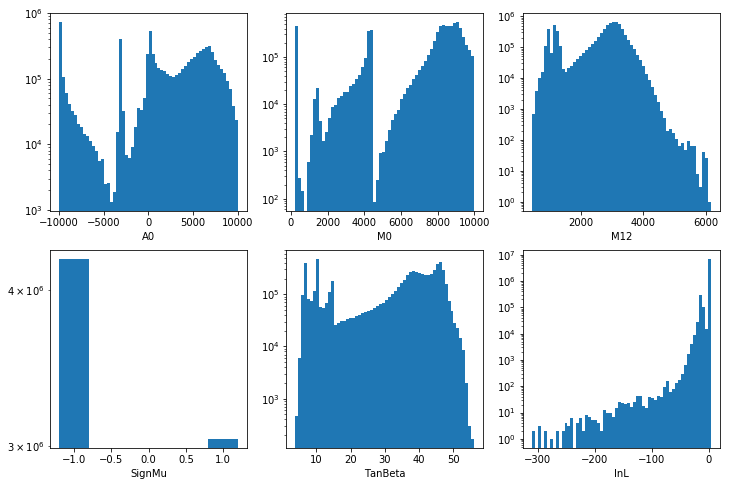

In [ ]:
for k in df:
    df[k].maximum = df[k].max()
    df[k].minimum = df[k].min()

    if k == 'SignMu':
        df[k].bins = np.linspace(-1.2, 1.2, 7)
    else:
        df[k].bins = np.linspace(df[k].minimum, df[k].maximum, 60+1)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
for k, ax in zip(df, axes.flatten()):
    ax.hist(df[k], bins=df[k].bins)
    ax.set_xlabel(k)
    ax.set_yscale('log')

As suspected there is much structure in these histograms, we will discuss the origin of these after plotting the 2D histograms below.
For now we focus on the lnL histogram. 
The dominating peak is at exactly 0, which is very specific and therefor unlikely value. 
It arises from a filtering step in the methodology of Gambit scan. The calculation of lnL is very expensive, and to avoid unnecessary calculations they check if the production cross-section (essentially normalisation of the signal) is even remotely large enough for the signal from cMSSM to be detectable in the considered analyses.
If it's not then the point is assigned lnL = 0, the likelihood of the Standard Model (i.e. background-only hypothesis).

This somewhat distort our view of lnL which might pose a problem in the machine learning phase.
A possible treatment is to include our own filter, either the same as Gambit necessitating cross-section calculations or a trained classifier.
Another is to jitter the zeros, adding noise and smoothing out discontinuities. 
However, we should remember to measure before cuttin, it might not be a problem at all.

The attentive reader might have noted that the max value of the lnL in the dataset is ~3, seemingly a better fit than the Standard Model!
This really due to fluctuations in the data, and in the final analysis the Gambit collaboration gives these point the value zero also.
There's no need for us to do the same, we would only lose information.

## 2D Histograms 

We will now plot the 2D histograms, or heatmaps as they are also known, of all combinations of the variables.
The colour denote the number of points in each bin, the color scale are different in each diagram and it's logarithmic.

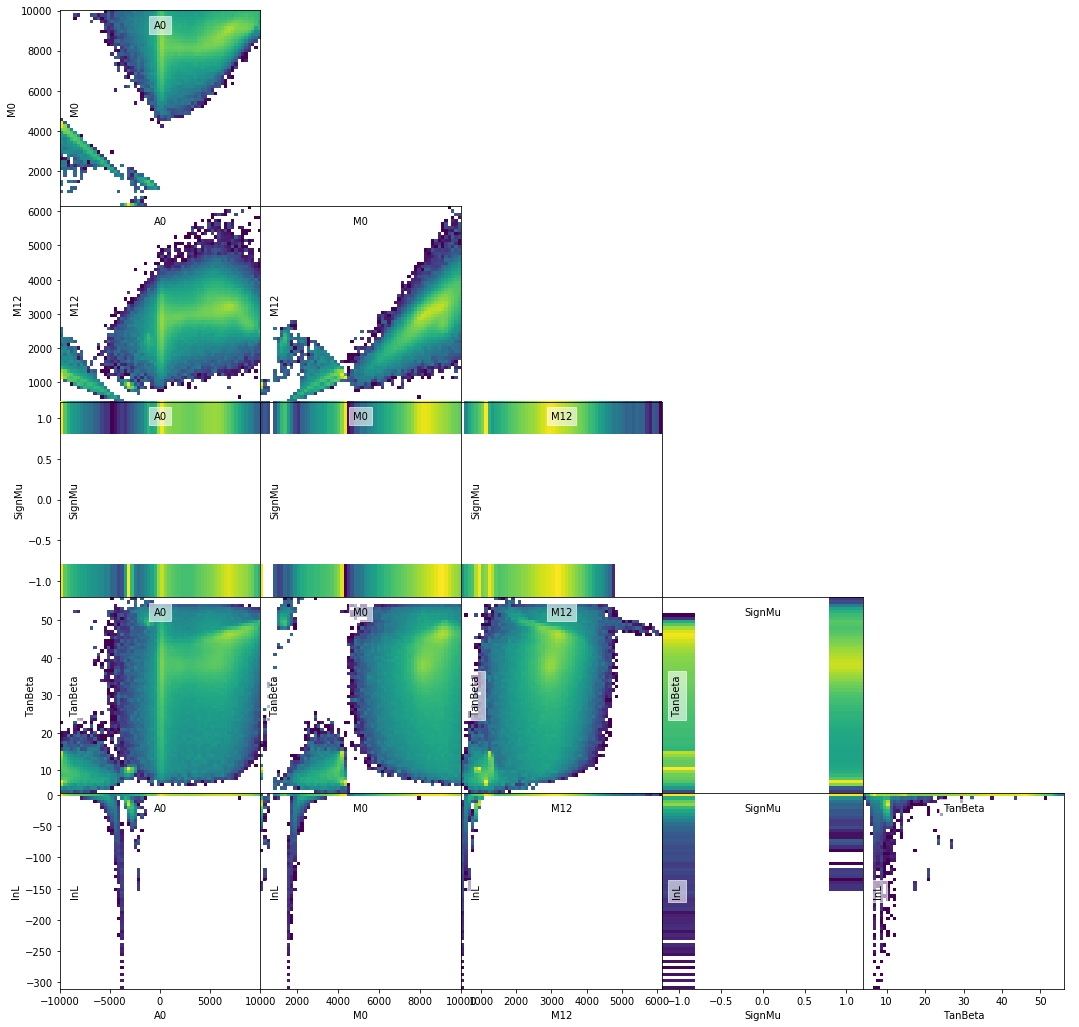

In [ ]:
nvar = df.shape[1]
fig, axes = plt.subplots(ncols=nvar-1, nrows=nvar-1, figsize=(nvar*3, nvar*3))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for i, x in enumerate(df):
    for j, y in enumerate(df):
        if i == nvar-1 or j == 0:
            continue
        
        ax = axes[j-1,i]

        if i >= j:
            ax.axis('off')
            continue

        ax.hist2d(df[x], df[y],
                  bins=(df[x].bins, df[y].bins),
                  cmap='viridis', norm=LogNorm())
                
        bbox_props = dict(fc='white', ec='white', alpha=0.6)
        ax.text(0.5, 0.95, x, transform=ax.transAxes, va='top', ha='center', bbox=bbox_props)
        ax.text(0.05, 0.5, y, transform=ax.transAxes, rotation=90, va='center', ha='left', bbox=bbox_props)
        
        if j == nvar-1:
            ax.set_xlabel(x)
        else:
            ax.set_xticks([])
        if i == 0:
            ax.set_ylabel(y)
        else:
            ax.set_yticks([])

The structures in the sampling becomes very explicit in 2D.
As we stated earlier the structure arises from the likelihood-driven scanning methodology used to sample the parameter space.
As we can see in the bottom row with much of the range feature less with regards to lnL, the likelihood used to the drive the scan is *not* our lnL however.
The scan by Gambit is a *global* analysis which combine data from many different experiments and observations, and it's the combined likelihood from all these that has driven the scan.

The dominant term in the combined likelihood is the relic density of dark matter.
This term demands that the relic density, the density left in the Universe today, of the lightest cMSSM neutralino must be equal to or smaller than the observed dark matter density from the Planck satellite's measurement of the Cosmic Microwave Background (CMB).

The relic density is inverse proportional to the neutralino-neutralino annihilation cross-section (i.e. how often when two neutralino meet they annihilated into other particles) and for much of the parameter space the cross-section is much too low to produce a small enough relic density.
Typically the cross-section much be enhanced by some *mechanism* such as a resonance or so-called co-annihilations.
We will not go into the details here but the different regions we observe in the sample are from different mechanisms. Figure 2 (p. 14) in the Gambit paper illustrate this.

This obviously limits our understanding of the LHC likelihood, we might be missing interesting features and behaviour in regions disfavoured by other constraints.
On the other hand these regions simply aren't interesting from a dark matter perspective so these potential features aren't actually interesting.
A interesting complication is of course identifying when we are asking the trained algorithm to extrapolate outside the training data.
This complication is nicely connected to the buisiness of active learning.

An additional observation is that for much of the parameter space the likelihood is zero. The space can be cut down by only considering A0 < ~0, M0 < ~5000, M12 < ~1500.